In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

In [0]:
batch_size = 128

In [0]:
transform = transforms.Compose([transforms.CenterCrop(64), 
                              transforms.ToTensor(),])

In [0]:
!wget http://groups.inf.ed.ac.uk/calvin/inria-horses-v103.tgz -O horses.tgz
!tar -zxvf inria-horses-v103.tgz

In [5]:
train_data = datasets.STL10('./', download=True, transform=transform)
trainloader = DataLoader(train_data, batch_size=batch_size)

In [0]:
inputs, labels = next(iter(trainloader))

tensor(3)
torch.Size([128, 3, 64, 64])


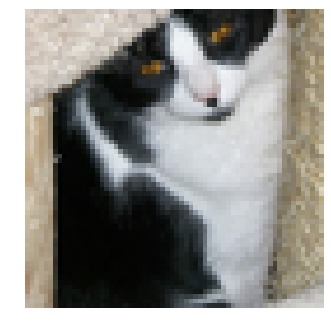

In [7]:
l = 39
print (labels[l])
plt.imshow(inputs[l].transpose(0, 1).transpose(1, 2).data.numpy())
plt.axis('off')
print (inputs.shape)

In [0]:
# Discriminator

# Probably a VGG16 or VGG19 for Simple Image Classification pretrained on ImageNet

class Discriminator(nn.Module):
    
    def __init__(self, c1_channels=64, c2_channels=128, c3_channels=256,
                 c4_channels=512, i_channels_in_2=True):
        '''
        The constructor method for the Discriminator class
        
        Arguments:
        - c1_channels : the number of output channels from the
                        first Convolutional Layer [Default - 128]
                        
        - c2_channels : the number of output channels from the
                        second Convolutional Layer [Default - 256]
                        
        - c3_channels : the number of output channels from the
                        third Convolutional Layer [Default - 512]
        
        - i_channels_in_2 : Increase the number of channels by 2
                        in each layer.
        '''
        
        super().__init__()
        
        # Define the class variables
        self.c1_channels = c1_channels
        
        if i_channels_in_2:
            self.c2_channels = self.c1_channels * 2
            self.c3_channels = self.c2_channels * 2
            self.c4_channels = self.c3_channels * 2
        else:
            self.c2_channels = c2_channels
            self.c3_channels = c3_channels
            self.c4_channels = c4_channels
        
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=self.c1_channels,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False)
        
        self.conv2 = nn.Conv2d(in_channels=self.c1_channels,
                               out_channels=self.c2_channels,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False)
        
        self.bnorm2 = nn.BatchNorm2d(num_features=self.c2_channels)
        
        self.conv3 = nn.Conv2d(in_channels=self.c2_channels,
                               out_channels=self.c3_channels,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False)
        
        self.bnorm3 = nn.BatchNorm2d(num_features=self.c3_channels)
        
        self.conv4 = nn.Conv2d(in_channels=self.c3_channels,
                               out_channels=self.c4_channels,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False)
        
        self.bnorm4 = nn.BatchNorm2d(num_features=self.c4_channels)
        
        self.fc1 = nn.Linear(8192, 1)
        
        self.lrelu = nn.LeakyReLU(negative_slope=0.2)
        
        
    def forward(self, img):
        '''
        The method for the forward pass in the network
        
        Arguments;
        - img : a torch.tensor that is of the shape N x C x H x W
                where, N - the batch_size
                       C - the number of channels
                       H - the height
                       W - the width
       
       Returns:
       - out : the output of the Discriminator 
               whether the passed image is real /fake
        '''
        
        #print (img.shape)
        
        batch_size = img.shape[0]
        
        x = self.lrelu(self.conv1(img))
        x = self.bnorm2(self.lrelu(self.conv2(x)))
        x = self.bnorm3(self.lrelu(self.conv3(x)))
        x = self.bnorm4(self.lrelu(self.conv4(x)))
        
        #print (x.size())
        
        x = x.view(batch_size, -1)
        #print (x.shape)
        
        #print (x.size())
        
        out = self.fc1(x)
        
        return out

In [9]:
dis = Discriminator()
z = np.random.uniform(-1, 1, size=(batch_size, 3, 64, 64))
z = torch.from_numpy(z).float()
print (z.shape)
out = dis(z)
out.shape

torch.Size([128, 3, 64, 64])


torch.Size([128, 1])

In [0]:
# Generator Hyperparameters

z_size = 100
z = np.random.uniform(-1, 1, size=(batch_size, z_size))

In [0]:
class Generator(nn.Module):
    def __init__(self, ct1_channels=1024, ct2_channels=512,
                 ct3_channels=256, ct4_channels=128, d_channels_in_2=True):
        
        '''
        The contructor class for the Generator
        
        Arguments:
        - zin_channels: ###
        
        - ct1_channels: The number of output channels for the
                        first ConvTranspose Layer. [Default - 1024]
        
        - ct2_channels: The number of putput channels for the
                        second ConvTranspose Layer. [Default - 512]
                        
        - ct3_channels: The number of putput channels for the
                        third ConvTranspose Layer. [Default - 256]
                        
        - ct4_channels: The number of putput channels for the
                        fourth ConvTranspose Layer. [Default - 128]
                        
        - d_channnels_in_2 : Decrease the number of channels 
                        by 2 times in each layer.
                        
        '''
        super().__init__()
        
        # Define the class variables
        self.ct1_channels = ct1_channels
        self.pheight = 4
        self.pwidth = 4
        
        if d_channels_in_2:
            self.ct2_channels = self.ct1_channels // 2
            self.ct3_channels = self.ct2_channels // 2
            self.ct4_channels = self.ct3_channels // 2
        else:
            self.ct2_channels = ct2_channels
            self.ct3_channels = ct3_channels
            self.ct4_channels = ct4_channels
            
        self.convt_1 = nn.ConvTranspose2d(in_channels=self.ct1_channels,
                                          out_channels=self.ct2_channels,
                                          kernel_size=4,
                                          stride=2,
                                          padding=1,
                                          bias=False)
        
        self.bnorm1 = nn.BatchNorm2d(num_features=self.ct2_channels)
        
        self.convt_2 = nn.ConvTranspose2d(in_channels=self.ct2_channels,
                                          out_channels=self.ct3_channels,
                                          kernel_size=4,
                                          stride=2,
                                          padding=1,
                                          bias=False)
        
        self.bnorm2 = nn.BatchNorm2d(num_features=self.ct3_channels)
        
        self.convt_3 = nn.ConvTranspose2d(in_channels=self.ct3_channels,
                                          out_channels=self.ct4_channels,
                                          kernel_size=4,
                                          stride=2,
                                          padding=1,
                                          bias=False)
        
        self.bnorm3 = nn.BatchNorm2d(num_features=self.ct4_channels)
        
        self.convt_4 = nn.ConvTranspose2d(in_channels=self.ct4_channels,
                                          out_channels=3,
                                          kernel_size=4,
                                          stride=2,
                                          padding=1,
                                          bias=False)
        
        self.fc1 = nn.Linear(z_size, self.pheight * self.pwidth * self.ct1_channels)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, z):
        '''
        The method for the forward pass for the Generator
        
        Arguments:
        - z : the input random uniform vector sampled from uniform distribution
        
        Returns:
        - out : The output of the forward pass through the network
        '''
        
        # Project the input z and reshape
        z = self.fc1(z)
        z = z.view(-1, self.ct1_channels, self.pheight, self.pwidth)
        
        #print (z.size())
        
        x = self.relu(self.bnorm1(self.convt_1(z)))
        #print (x.size())
        x = self.relu(self.bnorm2(self.convt_2(x)))
        #print (x.size())
        x = self.relu(self.bnorm3(self.convt_3(x)))
        #print (x.size())
        out = self.tanh(self.convt_4(x))
        
        return out

In [12]:
gen = Generator()
z = np.random.normal(loc=0, scale=0.02, size=(batch_size, z_size))
z = torch.from_numpy(z).float()
print (z.shape)
out = gen(z)
print (out.shape)

torch.Size([128, 100])
torch.Size([128, 3, 64, 64])


In [0]:
# Hyperparameters

z_size = 100

In [0]:
D = Discriminator()
G = Generator()

In [15]:
print (D)
print ()
print (G)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=8192, out_features=1, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.2)
)

Generator(
  (convt_1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bnorm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt_2): ConvTranspose2d(512, 

In [0]:
def scale(x, mx=1, mn=-1):
    '''
    Scale images to be in the range of -1 - +1
    This method assumes the pixel values in the image 
    are already in the range of 0 and 1
    '''
    x = x * (mx - mn) + mn
    return x

In [0]:
def real_loss(D_out, smooth=False, device='cuda'):
    batch_size = D_out.shape[0]
    labels = torch.ones(batch_size)
    
    labels = labels.to(device)
        
    if smooth:
        labels *= 0.9
        
    criterion = nn.BCEWithLogitsLoss().to(device)
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.shape[0]
    labels = torch.zeros(batch_size)

    labels = labels.to(device)
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [0]:
# Optimizers

d_lr = 0.0002
g_lr = 0.0002

d_opt = optim.Adam(D.parameters(), lr=d_lr, betas=[0.5, 0.999])
g_opt = optim.Adam(G.parameters(), lr=g_lr, betas=[.5, 0.999])

In [0]:
# Train loop

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

p_every = 127
t_every = 1
e_every = 1
epochs = 1200

train_losses = []
eval_losses = []

#dcgan = dcgan.to(device)
D = D.to(device)
G = G.to(device)

#dcgan.train()
D.train()
G.train()

for e in range(epochs):
    
    td_loss = 0
    tg_loss = 0
    
    for batch_i, (real_images, _) in enumerate(trainloader):
        
        # Scaling image to be between -1 and 1
        real_images = scale(real_images)
        
        real_images = real_images.to(device)
        
        batch_size = real_images.size(0)
        
        #### Train the Discriminator ####
        
        d_opt.zero_grad()

        #d_fake, d_real = dcgan(real_images, z)
        
        #print (real_images.shape)
        d_real = D(real_images)
        r_loss = real_loss(d_real, smooth=True, device=device)
        
        
        z = np.random.normal(loc=0, scale=0.02, size=(batch_size, z_size))
        z = torch.from_numpy(z).float().to(device)
        
        fake_images = G(z)
        
        d_fake = D(fake_images)
        
        f_loss = fake_loss(d_fake)
        
        d_loss = r_loss + f_loss
        
        td_loss += d_loss.item()
        
        d_loss.backward()
        d_opt.step()
        
        
        #### Train the Generator ####
        g_opt.zero_grad()
        
        z = np.random.normal(loc=0, scale=0.02, size=(batch_size, z_size))
        z = torch.from_numpy(z).float().to(device)
        
        fake_images = G(z)
        d_fake = D(fake_images)
        
        g_loss = real_loss(d_fake, device=device)
        
        tg_loss += g_loss.item()
        
        g_loss.backward()
        g_opt.step()
        
        if batch_i % p_every == 0:
            print ('Epoch [{:5d} / {:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'. \
                    format(e+1, epochs, d_loss, g_loss))
            
    train_losses.append([td_loss, tg_loss])
    
    if e % e_every:
        with torch.no_grad():
            G.eval()
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float().to(device)
            d_fake = dcgan(None, z)
            e_loss = real_loss(d_fake)
        G.train()
        
        eval_losses.append(e_loss)

print ('[INFO] Training Completed successfully!')

Epoch [    1 /  1200] | d_loss: 1.4898 | g_loss: 8.3411
Epoch [    2 /  1200] | d_loss: 0.4123 | g_loss: 6.7430
Epoch [    3 /  1200] | d_loss: 0.3981 | g_loss: 7.6735
Epoch [    4 /  1200] | d_loss: 0.3669 | g_loss: 7.9156
Epoch [    5 /  1200] | d_loss: 0.5908 | g_loss: 6.0695
Epoch [    6 /  1200] | d_loss: 0.6423 | g_loss: 6.2086
Epoch [    7 /  1200] | d_loss: 0.5654 | g_loss: 3.8183
Epoch [    8 /  1200] | d_loss: 0.5749 | g_loss: 3.9369
Epoch [    9 /  1200] | d_loss: 0.7041 | g_loss: 4.8909
Epoch [   10 /  1200] | d_loss: 0.7394 | g_loss: 3.9883
Epoch [   11 /  1200] | d_loss: 0.5243 | g_loss: 4.3384
Epoch [   12 /  1200] | d_loss: 0.5601 | g_loss: 4.5166
Epoch [   13 /  1200] | d_loss: 0.5210 | g_loss: 4.3073
Epoch [   14 /  1200] | d_loss: 0.5898 | g_loss: 4.2343
Epoch [   15 /  1200] | d_loss: 0.4967 | g_loss: 5.5028
Epoch [   16 /  1200] | d_loss: 0.4331 | g_loss: 4.7277
Epoch [   17 /  1200] | d_loss: 0.4770 | g_loss: 5.0686
Epoch [   18 /  1200] | d_loss: 0.4391 | g_loss:

In [0]:
z = np.random.normal(loc=0, scale=0.02, size=(batch_size, z_size))
z = torch.from_numpy(z).float().cuda()
G.eval()
f = G(z)
G.train()

NameError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 63.5, 63.5, -0.5)

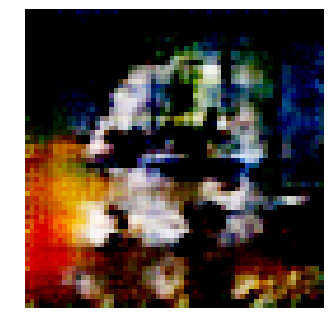

In [0]:
l = 78
plt.imshow(f[l].transpose(0, 1).transpose(1, 2).detach().cpu().data.numpy())
plt.axis('off')

In [0]:
def view_samples(images):
  if type(images) == torch.tensor:
    images = images.cpu().numpy()
    
  fig, axes = plt.subplots(figsize=(30, 30), nrows=8, ncols=8, sharey=True, sharex=True)
  
  for ax, img in zip(axes.flatten(), images):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.imshow(img)

In [0]:
ff = f.detach().cpu().transpose(1, 2).transpose(2, 3).numpy()
ff2 = inputs.detach().cpu().transpose(1, 2).transpose(2, 3).numpy()

In [1]:
ff2.shape

NameError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

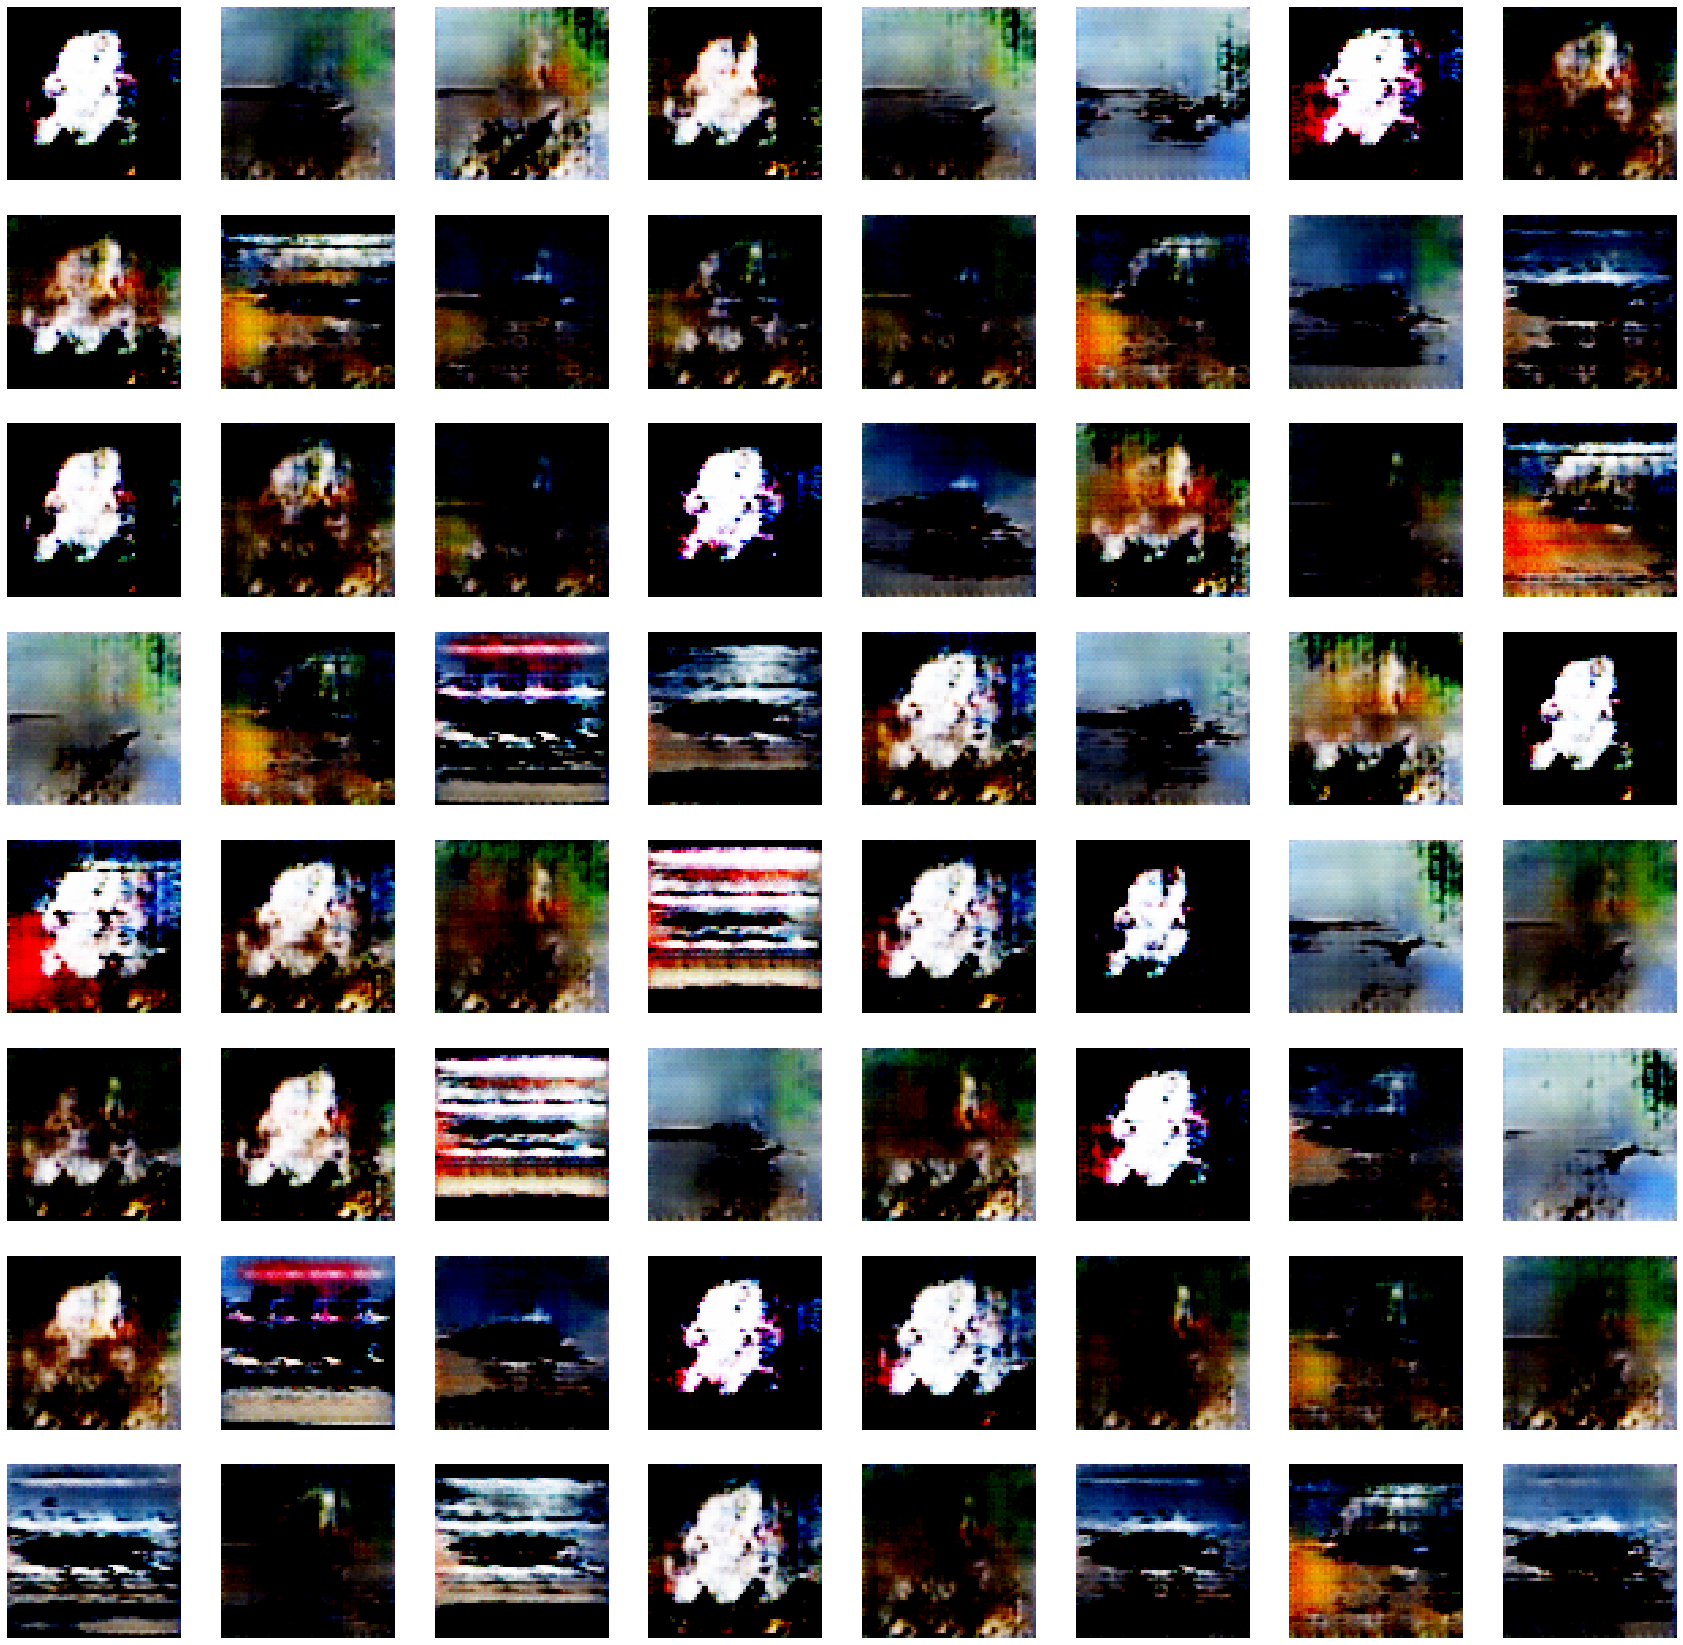

In [0]:
#view_samples(ff)
view_samples(ff)

In [0]:
np.min(ff[7])

-0.8835927

In [0]:
plt.imsave('DCGAN.png', ff)

TypeError: ignored

In [0]:
ff.shape

(80, 3, 32, 32)

In [0]:
d_ckpt = {
    'state_dict' : D.state_dict()
}

g_ckpt = {
    'state_dict' : G.state_dict()
}

In [0]:
torch.save(d_ckpt, 'd_ckpt.pth')
torch.save(g_ckpt, 'g_ckpt.pth')

In [0]:
class DCGAN(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        # Define the class variables
        
        self.G = Generator()
        self.D = Discriminator()
        
    def forward(self, real_images, z):
        
        fake_images = self.G(z)
        d_fake = self.D(fake_images)
        
        if not real_images is None:
            d_real = self.D(real_images)
            return d_fake, d_real
        
        return d_fake

In [0]:
d = DCGAN()
z2 = np.random.uniform(-1, 1, size=(batch_size, 3, 32, 32))
z1 = np.random.uniform(-1, 1, size=(batch_size, 100))
z1 = torch.from_numpy(z1).float()
z2 = torch.from_numpy(z2).float()

d_real, d_fake = d(z2, z1)
print (d_real.shape, d_fake.shape)

torch.Size([128, 1]) torch.Size([128, 1])


In [0]:
dcgan = DCGAN()

In [0]:
# Optimizers

d_lr = 0.002
g_lr = 0.002

d_opt = optim.Adam(dcgan.D.parameters(), lr=d_lr)
g_opt = optim.Adam(dcgan.G.parameters(), lr=g_lr)

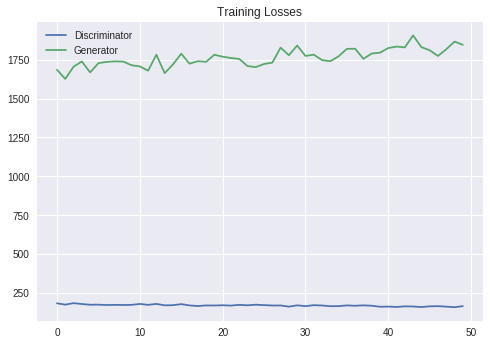

In [0]:
fig, ax = plt.subplots()
losses = np.array(train_losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title('Training Losses')
plt.legend()
plt.show()

In [0]:
def out_w(w, f, p, s):
    return ((w - f + (2 * p)) / s) + 1

In [0]:
w1 = out_w(4, 4, 1, 2)
w1

2.0

In [0]:
w2 = out_w(w1, 5, 0, 2)
w2

7.25

In [0]:
w3 = out_w(w2, 5, 1, 2)
w3

3.125

In [0]:
w4 = out_w(w3, 5, 1, 2)
w4

1.0625

In [0]:
inputs.shape

torch.Size([128, 3, 32, 32])

In [0]:
dcgan

DCGAN(
  (G): Generator(
    (convt_1): ConvTranspose2d(64, 1024, kernel_size=(1, 1), stride=(2, 2))
    (bnorm1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convt_2): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2))
    (bnorm2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convt_3): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2))
    (bnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convt_4): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2))
    (bnorm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convt_5): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2))
    (fc1): Linear(in_features=100, out_features=1024, bias=True)
    (relu): ReLU()
    (tanh): Tanh()
  )
  (D): Discriminator(
    (conv1): Conv2d(3, 64, kernel_size=(2, 2), stride=(2, 2))
    (bnorm1): BatchNorm2

In [0]:
def out_prev(w1, f, p, s):
    return ((w1 * s) - f - (2 * p) - s)

In [0]:
out_prev(32, 5, 1, 2)

55

In [0]:
out_prev(55, 5, 1, 2)

101